
# --------------------------------------- INITIALIZATION ---------------------------------------

# IMPORTING PYTHON PACKAGES

In [1]:
from glob import glob ## It is utilized for managing file paths and different files within Python. For more details on its usage and functionalities, please refer to >>> docs.python.org/3/library/glob.html
import rasterio as rio ## It is a module used for handling satellite imagery and various geospatial data to extract numerical data from image data. For more information, please refer to >>> rasterio.readthedocs.io
import numpy as np ## It is used for creating multi-dimensional arrays. For more information, please refer to >>> numpy.org
import earthpy.plot as ep ## It is used for plotting raster images. For more information, please refer to >>> earthpy.readthedocs.io
from skimage import io ## It is a module for image processing. For more details, please visit >>> scikit-image.org
import matplotlib.pyplot as plt ## It is a module for displaying images and various graphs. For more details, please visit >>> matplotlib.org

from matplotlib.colors import ListedColormap ## For defining the color boundaries used in image display

import pandas as pd ##  Module to facilitate easier data management, organizing data into a table format (Data Frame)  >>> pandas.pydata.org

import seaborn as sns ## This module is suitable for statistical graph visualization >>> seaborn.pydata.org

from IPython.display import Image as desc_fig ## For displaying images only

import warnings ## Module for managing Python kernel warning notifications
warnings.filterwarnings(action='ignore') ## Suppress all warnings from the system

# Set the PATH

In [97]:
POST_QPB_IMG_PATH = 'IMAGES/PB/1/' ## the directory where images are stored
POST_QPB = "R1_T47QPB_20210228T034701_" ## the names of the files in the directory
POST_QPB_GROUNDTRUTH_PATH = "R1_T47QPB_20210228T034701_GT_20m.tif" #the name of the image file for the answer keyPOST_QPB_IMG_SET = glob(f'{POST_QPB_IMG_PATH }{POST_QPB}*B?*.tif') #Use glob to collect paths and names of files specified
POST_QPB_IMG_SET.sort() ## Sort the images according to the spectral band order of Sentinel-2 satellite

# --------------------------------------- DATA ACQUISITION ---------------------------------------

# Import image data using Rasterio

In [98]:
POST_QPB_RASTER = np.array([]) ## Create a numpy array to store all the images converted to raster
_BUFF = [] ## Create a list to store raster data of each image

for _ in POST_QPB_IMG_SET:
    with rio.open(_, 'r') as img: ## Using rio to read satellite imagery and convert it into numerical form
        _BUFF.append(img.read(1))

POST_QPB_RASTER = np.stack(_BUFF) ## Convert the list storing raster data of each image into multi-dimensional arrays

Available_bands = [ 'Blue', 'Green', 'Red','VRE1','VRE2','VRE3', 'NIR', 'SWIR1', 'SWIR2'] ## List of bands used in the work, ordered accordingly

# Import the ground truth image(Ground Truth)

In [99]:
POST_QPB_GROUNDTRUTH = io.imread( ## Import the ground truth image using Skimage
    POST_QPB_IMG_PATH + POST_QPB_GROUNDTRUTH_PATH, ## Specify the file path
    as_gray=True ## Read the image in grayscale mode
) 
POST_QPB_GROUNDTRUTH_GRAY = np.array(POST_QPB_GROUNDTRUTH) ## Convert the list to a numpy array
intensity = 0.6 ## Set the intensity level from 0 to 1, where 0 represents the highest intensity
POST_QPB_GROUNDTRUTH_MASK = (POST_QPB_GROUNDTRUTH_GRAY < intensity).astype(int) ## Select only pixels with intensity values lower than the specified intensity

# --------------------------------------- DATA EXPLORATION ---------------------------------------

# 1.Plot The ground truth image on a true color composite image

### 1.1 Converting data

In [100]:
rgb_raster = np.stack([ ## Chose band Red,Green,Blue from Raster Array
    POST_QPB_RASTER[2], ## Red
    POST_QPB_RASTER[1], ## Green
    POST_QPB_RASTER[0]]) ## Blue

print("Shape before move axis: ",rgb_raster.shape)
     
new_rgb_raster = np.moveaxis(rgb_raster, 0, -1) ## Change the dimensions of the array

print("Shape after move axis: ",new_rgb_raster.shape)

Shape before move axis:  (3, 500, 500)
Shape after move axis:  (500, 500, 3)


In [101]:
rgb_Image = new_rgb_raster/np.amax(new_rgb_raster) ## Increase the brightness of the image
rgb_Image = np.clip(rgb_Image, 0, 1) ## Set the boundaries of the color values not less than 0 and not greater than 1

### 1.2 Display the image

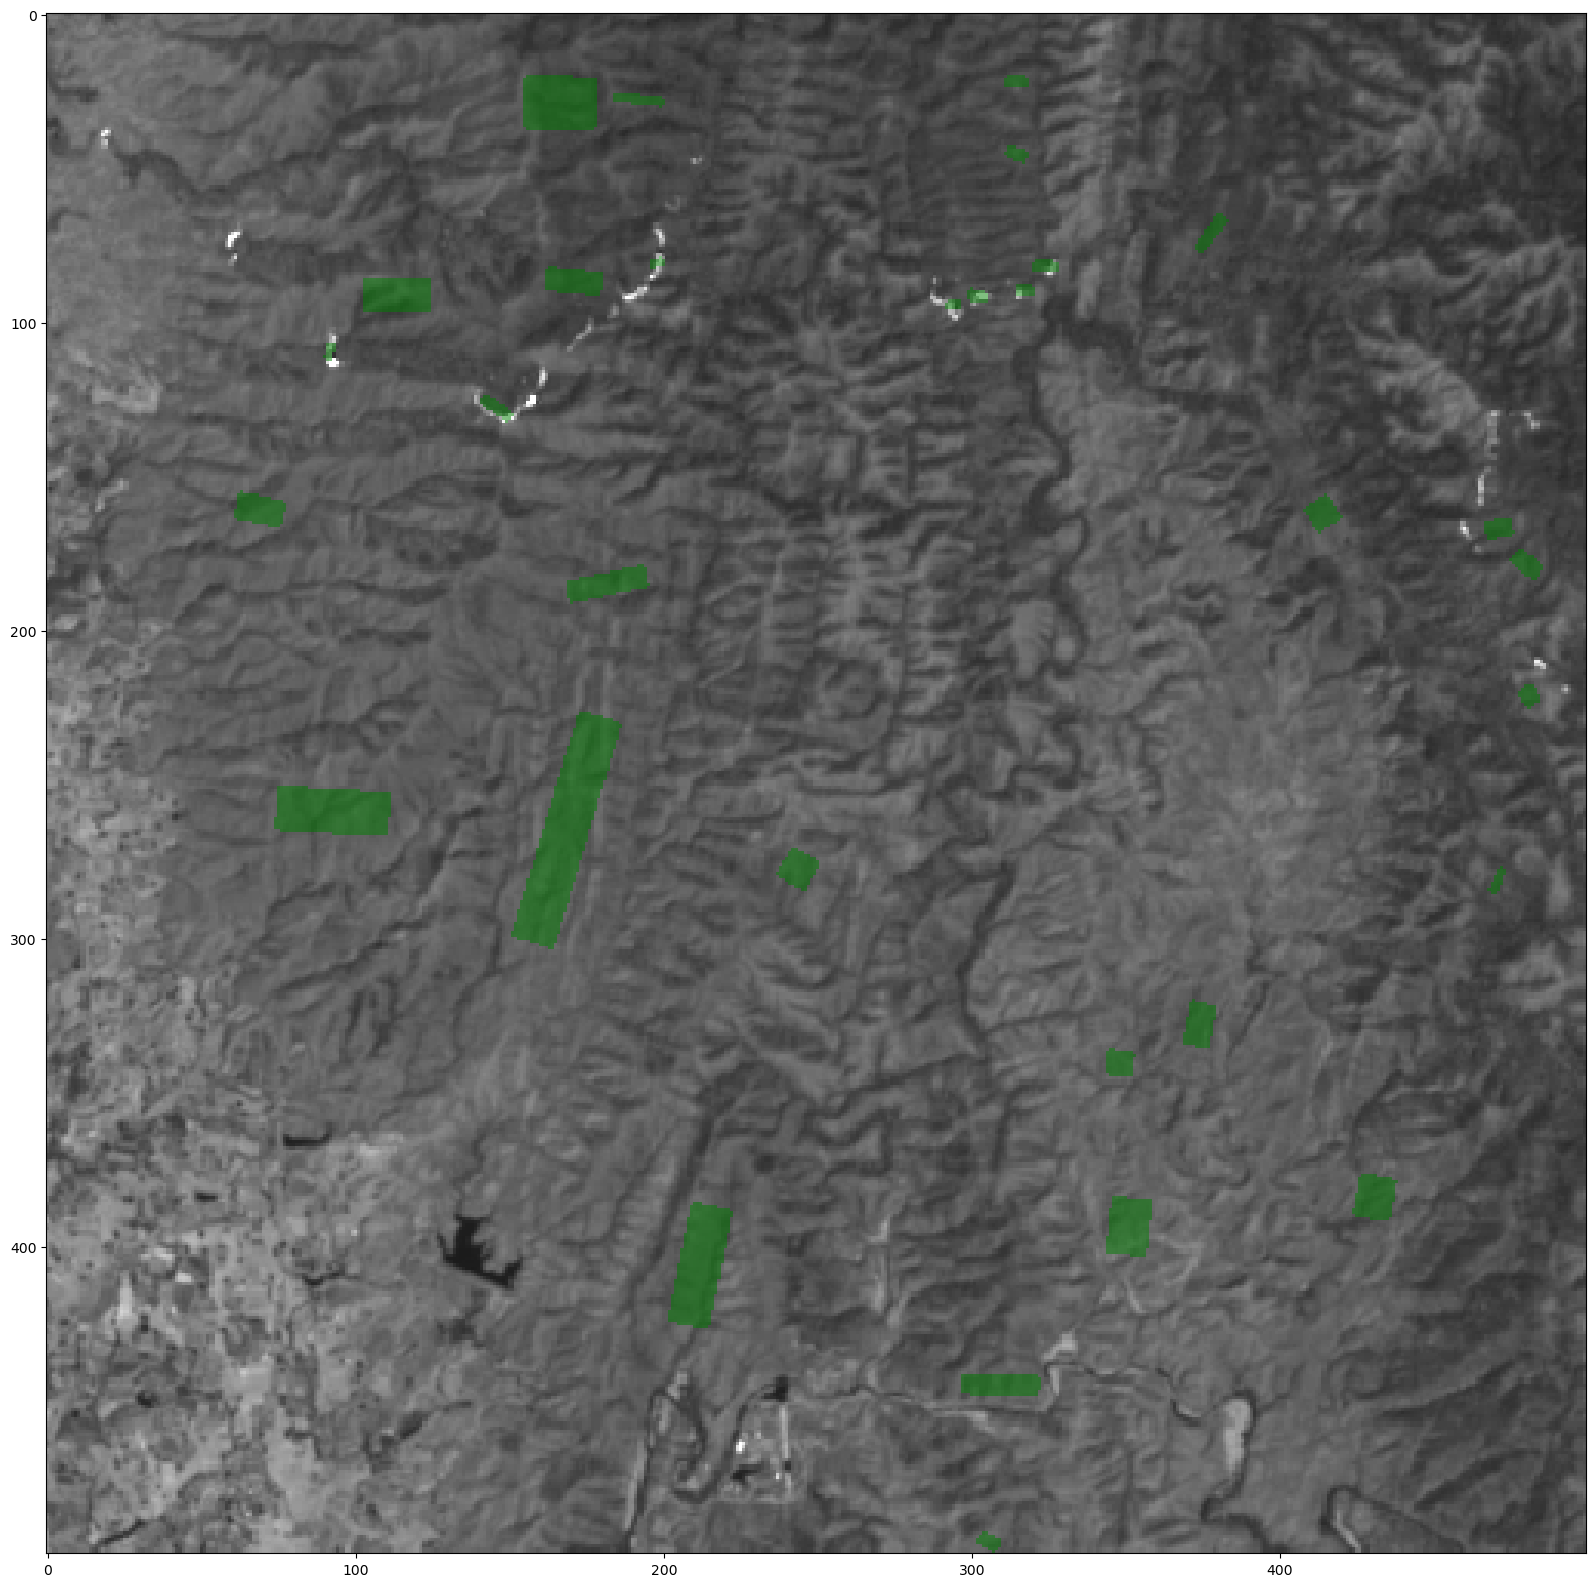

In [102]:
plt.figure(figsize=(20,20)) 
plt.imshow(POST_QPB_RASTER[8], cmap='gray',alpha=0.9)  

plt.imshow(POST_QPB_GROUNDTRUTH_MASK,
           vmin=0, 
           vmax=1, 
           cmap=ListedColormap(['#ffffff00','green']), ## Define color attributes, color value of 0, color value of 1 (#ffffff00 is Transparent)
           interpolation='none' , 
           alpha=0.5 ## Transparency (adjustable from 0 to 1, where 1 is the most opaque)
)

# 2.Convert Data for Model Training

### 2.1 Convert the array to a DataFrame

#### 2.1.1 Image data

In [103]:
POST_QPB_DF =  np.moveaxis(POST_QPB_RASTER, 0, -1) ## Change the dimensions of the array
print("Before re-shape:",POST_QPB_DF.shape)
POST_QPB_DF = POST_QPB_DF.reshape(-1, 9) ## Reshape the array
print("After re-shape:",POST_QPB_DF.shape)

Before re-shape: (500, 500, 9)
After re-shape: (250000, 9)


In [104]:
POST_QPB_DF = pd.DataFrame(POST_QPB_DF) ## Convert the array to a DataFrame
display(POST_QPB_DF)

,0,1,2,3,4,5,6,7,8
0,19,24,41,43,62,73,86,135,106
1,22,28,53,53,69,74,92,136,108
2,20,25,46,49,68,74,89,132,102
3,21,28,51,51,67,70,90,128,101
4,19,23,41,42,57,62,75,118,98
...,...,...,...,...,...,...,...,...,...
249995,8,12,27,29,49,60,78,111,74
249996,8,12,27,29,49,57,78,96,63
249997,8,11,20,25,47,51,73,88,57
249998,9,10,21,22,44,64,68,88,57


#### 2.1.2 Ground Truth

In [105]:
POST_QPB_GROUNDTRUTH_DF = POST_QPB_GROUNDTRUTH_MASK.reshape(-1)
print("Shape: ",POST_QPB_GROUNDTRUTH_DF.shape)

Shape:  (250000,)


In [106]:
POST_QPB_GROUNDTRUTH_DF = pd.DataFrame(POST_QPB_GROUNDTRUTH_DF)
display(POST_QPB_GROUNDTRUTH_DF)

,0
0,0
1,0
2,0
3,0
4,0
...,...
249995,0
249996,0
249997,0
249998,0


### 2.2 Rename Feature

#### 2.2.1 Image data

In [107]:
for _ in range(0,len(Available_bands)): ## Loop to rename according to the list of bands specified initially (Available_bands)
    POST_QPB_DF = POST_QPB_DF.rename(columns={_: Available_bands[_]})
display(POST_QPB_DF)

,Blue,Green,Red,VRE1,VRE2,VRE3,NIR,SWIR1,SWIR2
0,19,24,41,43,62,73,86,135,106
1,22,28,53,53,69,74,92,136,108
2,20,25,46,49,68,74,89,132,102
3,21,28,51,51,67,70,90,128,101
4,19,23,41,42,57,62,75,118,98
...,...,...,...,...,...,...,...,...,...
249995,8,12,27,29,49,60,78,111,74
249996,8,12,27,29,49,57,78,96,63
249997,8,11,20,25,47,51,73,88,57
249998,9,10,21,22,44,64,68,88,57


#### 2.2.2 Ground Truth

In [108]:
POST_QPB_GROUNDTRUTH_DF = POST_QPB_GROUNDTRUTH_DF.rename(columns={0: 'Label'})
display(POST_QPB_GROUNDTRUTH_DF)

,Label
0,0
1,0
2,0
3,0
4,0
...,...
249995,0
249996,0
249997,0
249998,0


# 3. Explore Preliminary Data from DataFrame

## 3.1 Data Types of Each Feature (DATA TYPE)

In [109]:
POST_QPB_DF.dtypes

Blue     uint8
Green    uint8
Red      uint8
VRE1     uint8
VRE2     uint8
VRE3     uint8
NIR      uint8
SWIR1    uint8
SWIR2    uint8
dtype: object

## 3.2 Checking for Missing Values (MISSING VALUE)

In [110]:
POST_QPB_DF.isnull().sum()

Blue     0
Green    0
Red      0
VRE1     0
VRE2     0
VRE3     0
NIR      0
SWIR1    0
SWIR2    0
dtype: int64

## 3.3 Statistical Information of the Data (STATISTICAL INFORMATION)

In [111]:
POST_QPB_DF.describe()

,Blue,Green,Red,VRE1,VRE2,VRE3,NIR,SWIR1,SWIR2
count,250000.000000,250000.000000,250000.000000,250000.000000,250000.000000,250000.000000,250000.000000,250000.000000,250000.000000
mean,15.628612,18.385764,31.581524,33.083400,51.240536,60.176476,74.994352,99.614600,73.760476
std,4.338869,5.203687,8.489614,8.302722,10.016258,12.755617,15.356414,22.421941,21.766991
min,4.000000,4.000000,9.000000,10.000000,16.000000,15.000000,10.000000,5.000000,4.000000
25%,13.000000,15.000000,26.000000,27.000000,44.000000,51.000000,64.000000,84.000000,58.000000
50%,15.000000,18.000000,31.000000,32.000000,50.000000,59.000000,75.000000,97.000000,74.000000
75%,18.000000,21.000000,36.000000,38.000000,57.000000,68.000000,85.000000,113.000000,87.000000
max,52.000000,70.000000,111.000000,111.000000,120.000000,148.000000,175.000000,255.000000,255.000000


## 3.4 Data Distribution (DISTRIBUTION)

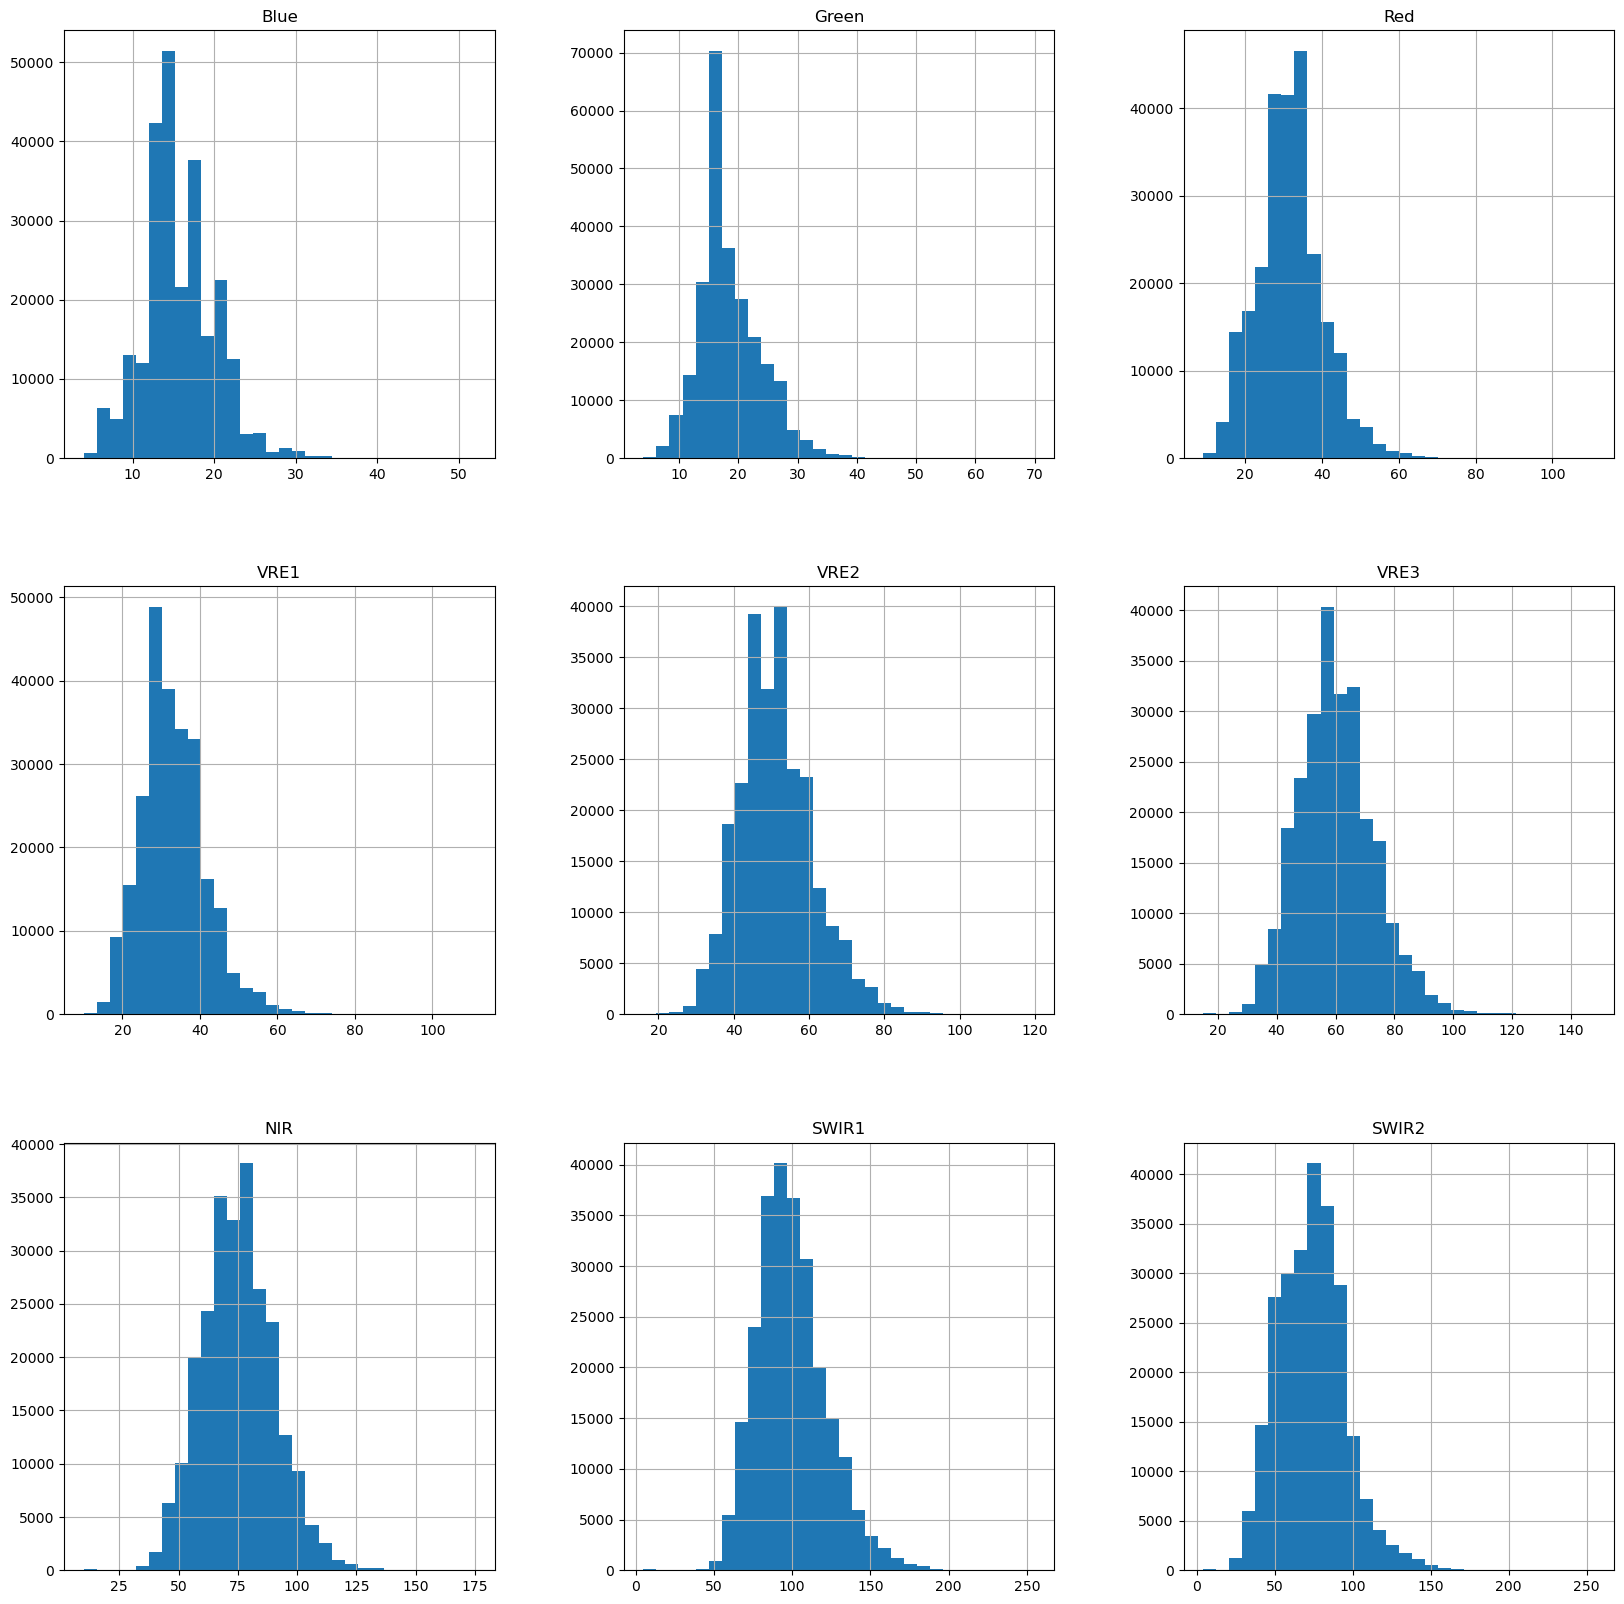

In [112]:
POST_QPB_DF.hist( ## Display the distribution of data for each feature
    bins=30, ## specifies the number of bins
    figsize=(20, 20), 
    layout=(3, 3) ## specifies the arrangement of subplots in a 3x3 grid
);

## 3.5 Outlier Detection (OUTLIER)

### In statistics, outliers are data points that differ significantly from other observations
<img src="DescriptionFigures/outlier1.png" width=600 height=600>
<img src="DescriptionFigures/outlier2.png" width=600 height=600>

### Plot outliers of each feature using seaborn

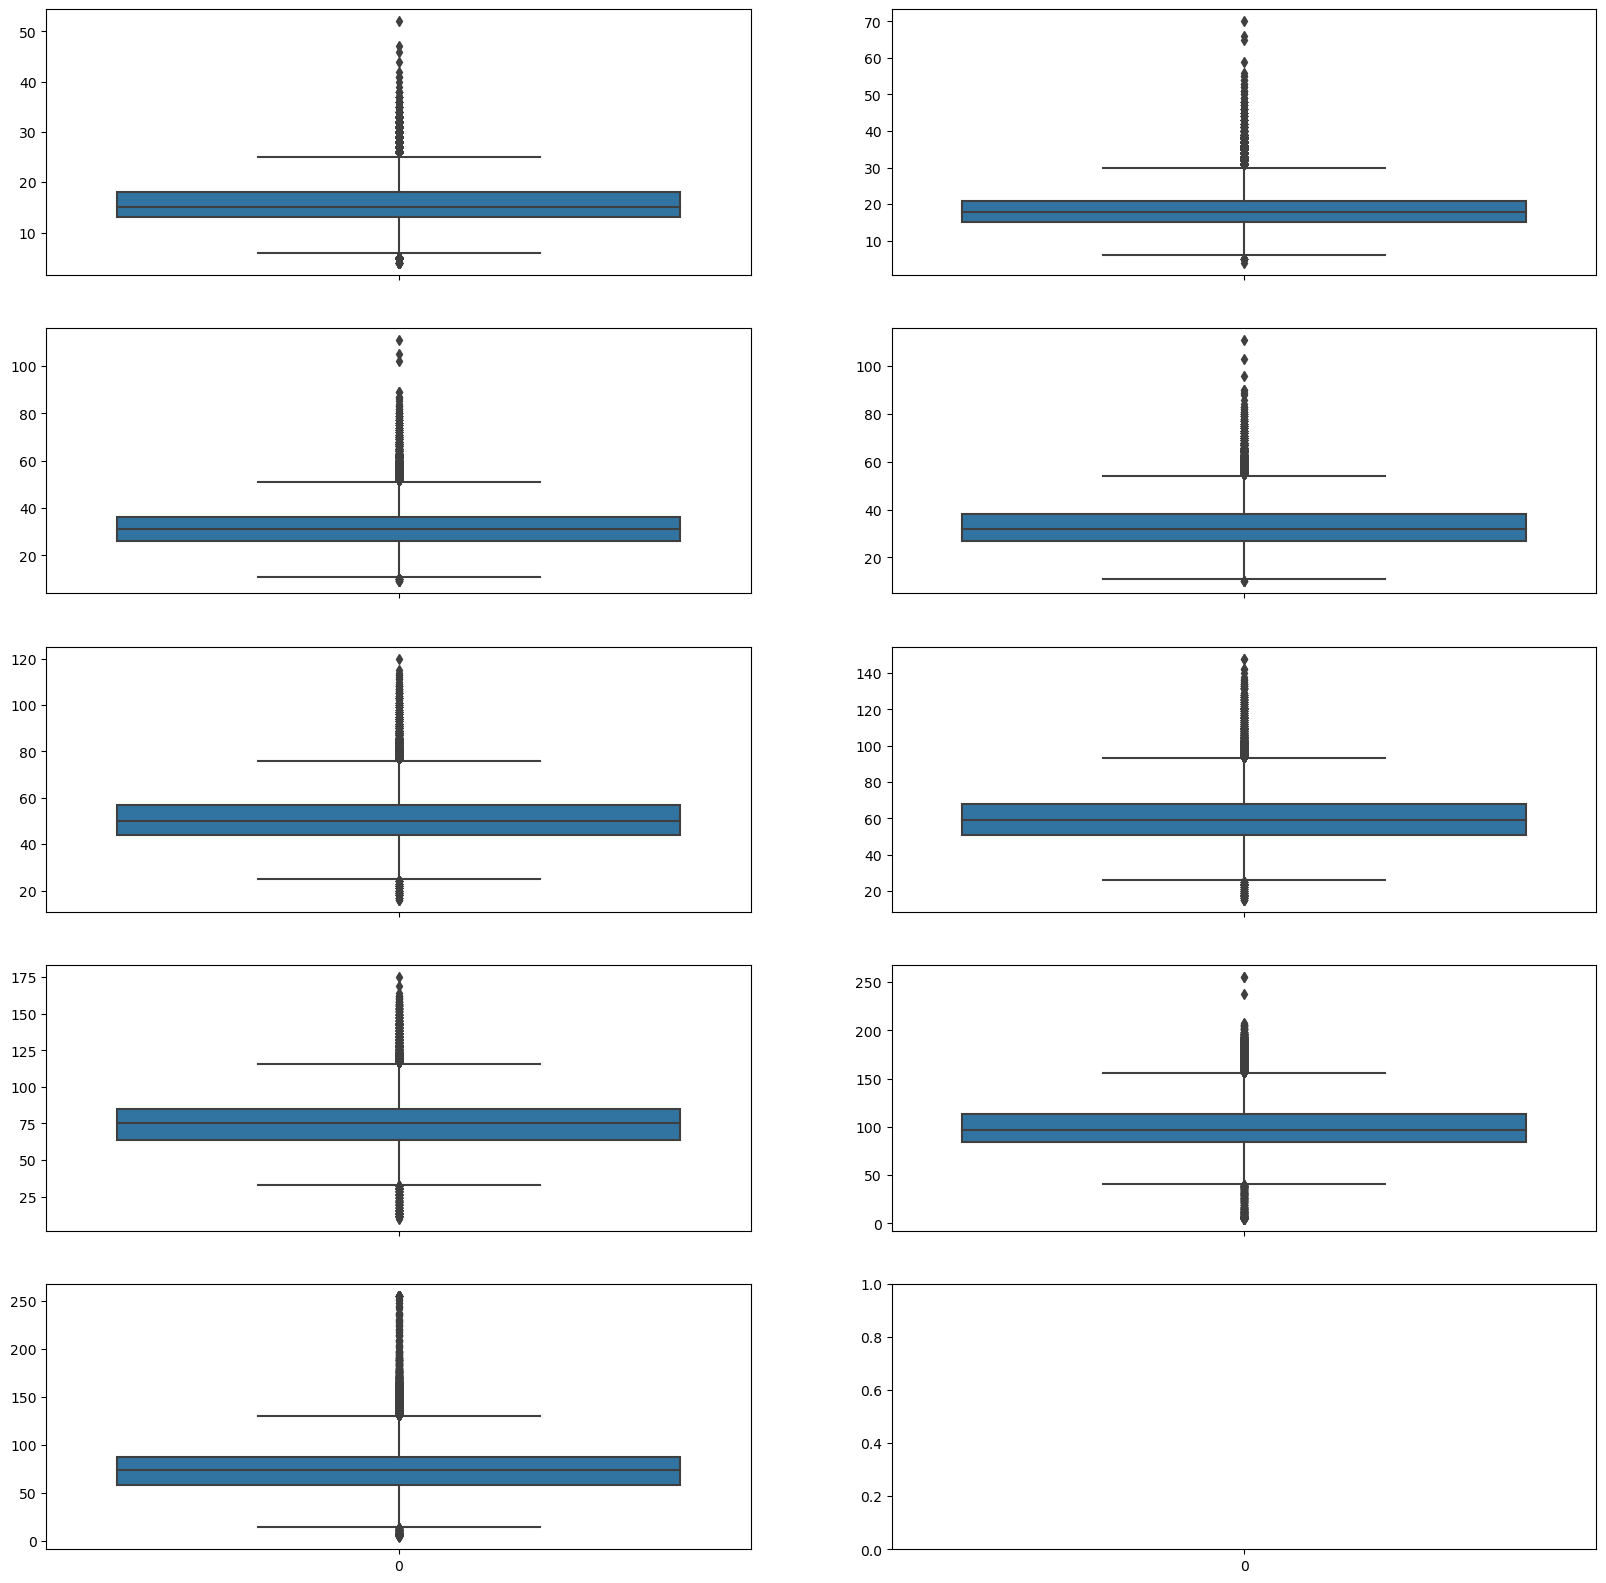

In [113]:
f, axes = plt.subplots(5, 2, figsize=(20, 20), sharex=True) ## Define the plotting format.

for ax, feature in zip(axes.flat, POST_QPB_DF.columns): ## Display outliers for each feature
    sns.boxplot(POST_QPB_DF[feature], ax=ax)

## 3.6 Relationship between features

<Axes: >

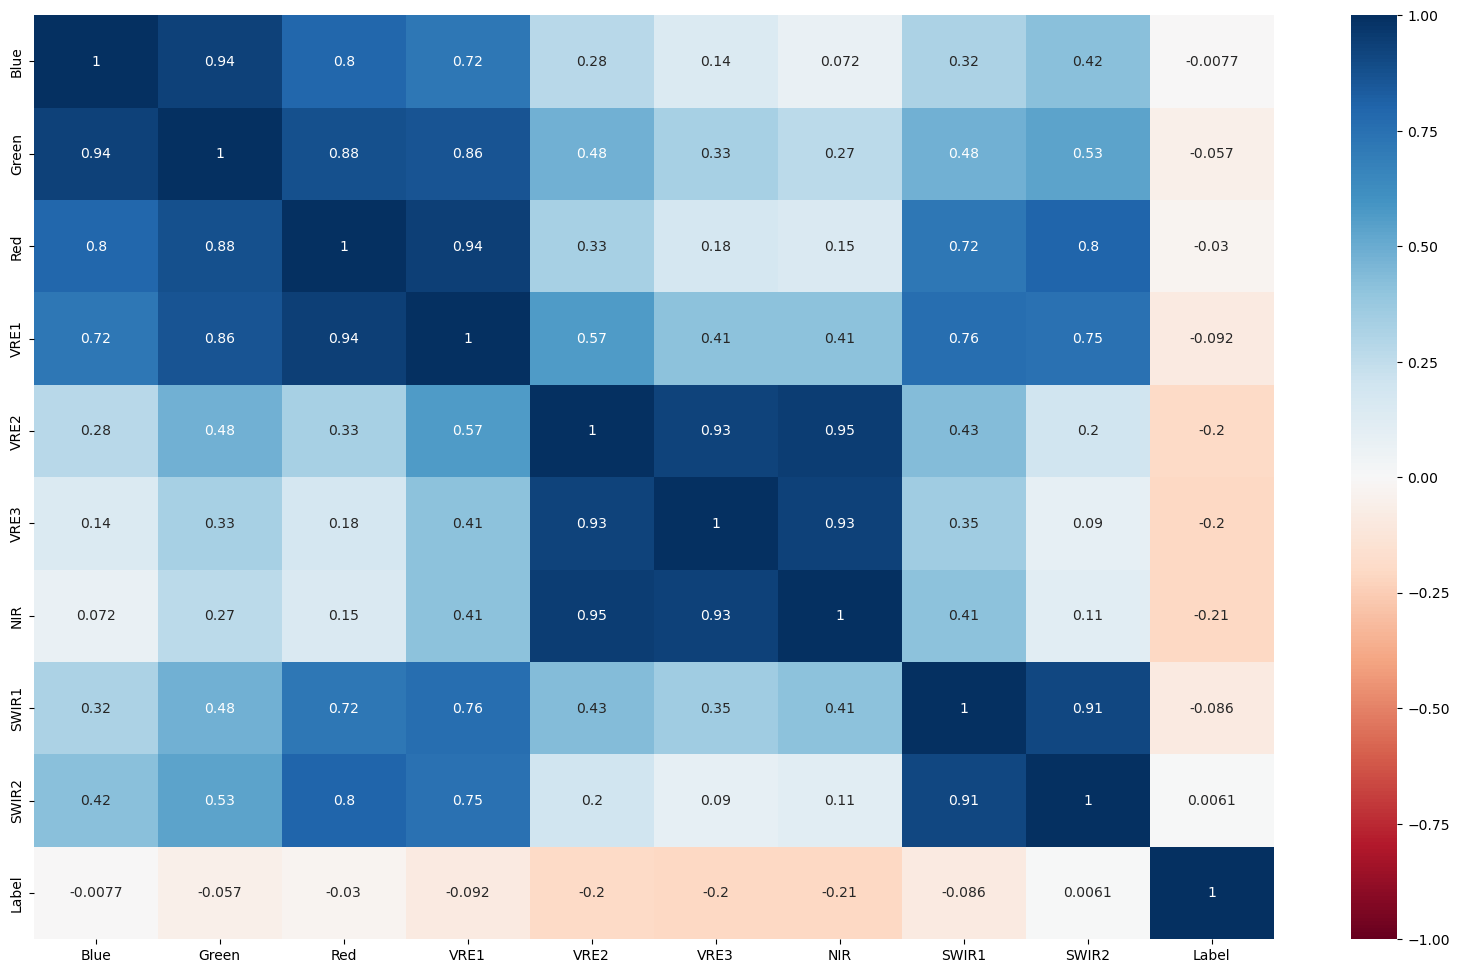

In [114]:
corr = pd.concat([POST_QPB_DF, POST_QPB_GROUNDTRUTH_DF], ## Concatenate 2 dataframes in order with concat command
                   axis=1, ## Merging in a column-wise manner
                   sort=False ## Do not sort the data
                  ).corr() ## Function to find the correlation between features

plt.figure(figsize=(20, 12))

sns.heatmap(corr, ##Display correlation values in heatmap format
            cmap="RdBu", ## Set the color scheme
            vmin=-1,
            vmax=1,
            annot=True ## Show numerical values
           )

## 3.7 Explore the number of answers in the ground truth

In [115]:
class_0_num = len(POST_QPB_GROUNDTRUTH_DF[POST_QPB_GROUNDTRUTH_DF.Label == 0])  ## Find the number of Class 0
class_1_num = len(POST_QPB_GROUNDTRUTH_DF[POST_QPB_GROUNDTRUTH_DF.Label == 1]) ## Find the number of Class 1
rows_num = len(POST_QPB_GROUNDTRUTH_DF.index) ## Find the total number of rows

print(f'Number of row: {rows_num}')
print(f'Number of Unburn class: {class_0_num} ({round((class_0_num/rows_num)*100,2)} %)')
print(f'Number of Burnt class: {class_1_num} ({round((class_1_num/rows_num)*100,2)} %)')

Number of row: 250000
Number of Unburn class: 245087 (98.03 %)
Number of Burnt class: 4913 (1.97 %)
